In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional non-linear elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [4]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import gpytorch
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [5]:
ROOT = "."
assert os.path.isfile(ROOT+"/elliptic_pde_1d.ipynb")

In [6]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [7]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

We will randomly generate
$$v(x) = \exp\left(-\frac{1}{1-r(x)^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r(x)=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

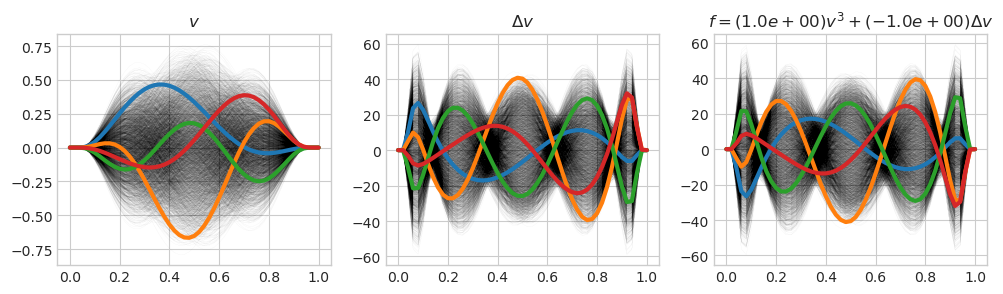

In [8]:
C1 = 1.
C2 = -1#-1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**12
P = 3
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True,t_lms=32)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 51
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
    coloridxs = torch.arange(4)
    ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
    ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
    ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
    ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
    ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
    ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
    ax[0].set_title(r"$v$")
    ax[1].set_title(r"$\Delta v$")
    ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## GP for PDE Solves

In [9]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

In [10]:
noise = 1e-8
#dd_obj = qp.DigitalNetB2(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=2e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant

r from 0 to 4096, l2 relative errors
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
r = 256: [1.0e+00 1.1e-02 2.3e-04 2.4e-04 2.4e-04 2.4e-04]
r = 512: [1.0e+00 2.1e-02 1.5e-04 1.3e-04 1.3e-04 1.3e-04]
r = 768: [1.0e+00 1.2e-02 2.6e-05 2.6e-05 2.6e-05 2.6e-05]
r = 1024: [1.0e+00 1.3e-02 4.4e-04 4.4e-04 4.4e-04 4.4e-04]
r = 1280: [1.0e+00 5.3e-03 4.7e-04 4.7e-04 4.7e-04 4.7e-04]
r = 1536: [1.0e+00 1.2e-02 9.7e-05 9.9e-05 9.9e-05 9.9e-05]
r = 1792: [1.0e+00 2.4e-02 1.7e-04 1.5e-04 1.5e-04 1.5e-04]
r = 2048: [1.0e+00 4.9e-03 3.1e-04 3.1e-04 3.1e-04 3.1e-04]
r = 2304: [1.0e+00 1.6e-02 8.1e-05 7.3e-05 7.3e-05 7.3e-05]
r = 2560: [1.0e+00 1.3e-02 1.7e-04 1.7e-04 1.7e-04 1.7e-04]
r = 2816: [1.0e+00 9.5e-03 5.1e-04 5.1e-04 5.1e-04 5.1e-04]
r = 3072: [1.0e+00 1.4e-02 5.6e-05 5.4e-05 5.4e-05 5.4e-05]
r = 3328: [1.0e+00 1.5e-02 1.4e-04 1.4e-04 1.4e-04 1.4e-04]
r = 3584: [1.0e+00 4.8e-03 4.5e-04 4.5e-04 4.5e-04 4.5e-04]
r = 3840: [1.0e+00 6.3e-0

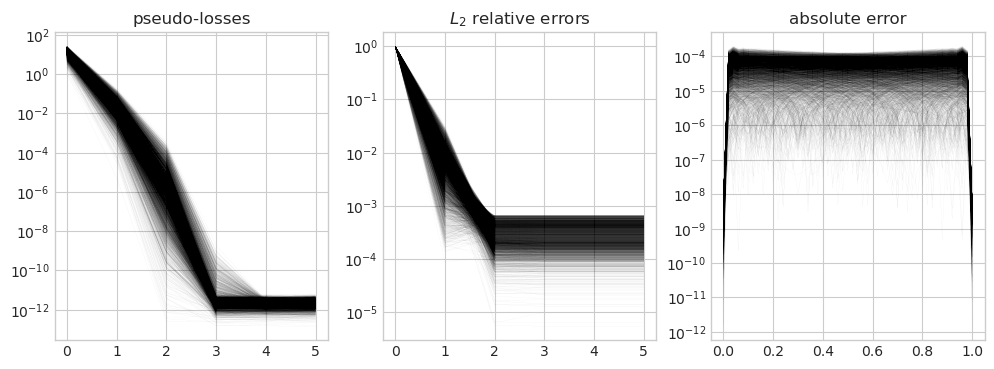

In [11]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"elliptic_pde_1d_data",tag)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,ki.ntot,ki.ntot))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//16
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(data_r["zhist"][:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
                    print(data["l2relerrors"][r])
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["l2relerrors"]),
        torch.from_numpy(data["L_chols"]))
maxiter = 5
vopt,losses_opt,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="bigeasy",force_gen=False)
print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
    ax[0].set_title("pseudo-losses")
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
    ax[0].set_yscale("log",base=10)
    ax[1].set_title(r"$L_2$ relative errors")
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
    ax[1].set_yscale("log",base=10)
    ax[2].set_title("absolute error")
    ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
    ax[2].set_yscale("log",base=10);

## Data

### Train-test split

In [12]:
(
uticks_train,uticks_val,
vopt_train,vopt_val,
vticks_train,vticks_val,
L_chols_train,L_chols_val,
) = qp.train_val_split(R,[uticks,vopt,vticks,L_chols],val_frac=1/8,shuffle=False)
print("uticks_train.shape:",tuple(uticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("uticks_val.shape:",tuple(uticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

uticks_train.shape: (3584, 51)
vopt_train.shape: (3584, 6, 104)
vticks_train.shape: (3584, 51)
L_chols_train.shape: (3584, 5, 53, 53)

uticks_val.shape: (512, 51)
vopt_val.shape: (512, 6, 104)
vticks_val.shape: (512, 51)
L_chols_val.shape: (512, 5, 53, 53)


## Operator Learning Lower Triangular Matrix

In [39]:
relaxations = torch.tensor([5e-2])
dataset_chonknoris_train = qp.DatasetLowerTriMatOpLearn(vopt_train[:,:,:nxticks],L_chols_train,relaxations=relaxations,device=DEVICE,steps=4,fp32=False)
dataset_chonknoris_val = qp.DatasetLowerTriMatOpLearn(vopt_val[:,:,:nxticks],L_chols_val,relaxations=relaxations,device=DEVICE,steps=4,fp32=False)
dataloader_chonknoris_train = torch.utils.data.DataLoader(dataset_chonknoris_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_chonknoris_val = torch.utils.data.DataLoader(dataset_chonknoris_val,batch_size=len(dataset_chonknoris_val),collate_fn=tuple,shuffle=False)
print("len(dataset_chonknoris_train):",len(dataset_chonknoris_train))
print("len(dataset_chonknoris_val):",len(dataset_chonknoris_val))
print("len(dataloader_chonknoris_train):",len(dataloader_chonknoris_train))
print("len(dataloader_chonknoris_val):",len(dataloader_chonknoris_val))

len(dataset_chonknoris_train): 10753
len(dataset_chonknoris_val): 1537
len(dataloader_chonknoris_train): 43
len(dataloader_chonknoris_val): 1


### MLP

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "NORIS_MLP_debug"
resume = True

mlp = qp.MultilayerPerceptron(
    mlp_layer_nodes = [dataset_chonknoris_train.v.size(-1),500,1000,(1+(nxticks+2))*(nxticks+2)//2],
    activation_function = torch.nn.Tanh(),
    batch_norm = False)

mlp = mlp.to(torch.float64)
noris_mlp = qp.LMOpLearnLowerTriMatMLP(mlp,automatic_optimization=True,fnorm_weight=1.,kl_weight=0.)

assert noris_mlp.ftype==dataset_chonknoris_train.v.dtype
print(noris_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 50,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_mlp, 
    train_dataloaders = dataloader_chonknoris_train,
    val_dataloaders = dataloader_chonknoris_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_MLP_debug/csv exists and is not empty. Previous log files in this directory will be deleted when the 

LMOpLearnLowerTriMatMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=51, out_features=500, bias=True)
      (1): Tanh()
      (2): Linear(in_features=500, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=1431, bias=True)
    )
  )
)



Sanity Checking: |                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


train_fnorm  val_fnorm  train_kl  val_kl  train_loss  val_loss
0      0.055881   0.021359       NaN     NaN    0.055881  0.021359
5      0.003222   0.005447       NaN     NaN    0.003222  0.005447
10     0.003619   0.004436       NaN     NaN    0.003619  0.004436
15     0.002729   0.003973       NaN     NaN    0.002729  0.003973
20     0.001965   0.002468       NaN     NaN    0.001965  0.002468
25     0.001925   0.001646       NaN     NaN    0.001925  0.001646
30     0.001319   0.002596       NaN     NaN    0.001319  0.002596
35     0.001875   0.003453       NaN     NaN    0.001875  0.003453
40     0.001060   0.002511       NaN     NaN    0.001060  0.002511
45     0.001118   0.001771       NaN     NaN    0.001118  0.001771

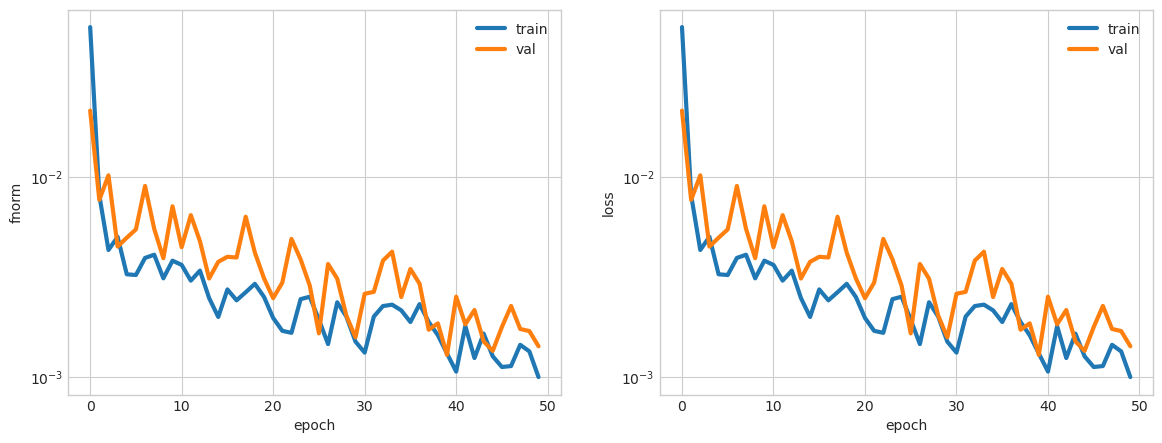

In [17]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics,tags=["fnorm","loss"])
metrics.iloc[::max(1,len(metrics)//10)]

### GP

In [40]:
save_dir = ROOT+"/"
name = "NORIS_GP_debug"
resume = True

import gc
gc.collect()
torch.cuda.empty_cache()

gp = qp.IndepVecVGP(num_inducing_pts=16,num_tasks=(1+(nxticks+2))*(nxticks+2)//2,dimension=dataset_chonknoris_train.v.size(-1))
gp = gp.double()

noris_gp = qp.LMOpLearnLowerTriMatGP(gp, 
                 automatic_optimization = True, 
                 input_relaxation = False,
                 fixed_noise = True)

assert noris_gp.ftype==dataset_chonknoris_train.v.dtype
print(noris_gp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 35,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )

trainer.fit(
    model = noris_gp, 
    train_dataloaders = dataloader_chonknoris_train,
    val_dataloaders = dataloader_chonknoris_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_GP_debug/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_GP_debug/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/NORIS_GP_debug/csv/checkpoints/epoch=24-step=1075.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,

LMOpLearnLowerTriMatGP(
  (gp): IndepVecVGP(
    (variational_strategy): IndependentMultitaskVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RQKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_alpha_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (mll): VariationalELBO(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_noise_constraint): GreaterThan(1.000E-08)
    )
    (model): IndepVecVGP(
      (variational_strategy): IndependentMultitaskVariationalStrategy(
        (base_variational_strategy): VariationalStrategy(
          (_variational_distribution): CholeskyVariationalDistribution()
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): RQKernel(
        

Sanity Checking: |                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

Validation: |                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


train_fnorm  val_fnorm    train_loss      val_loss
0      0.278235   0.081718  1.336938e+10  4.934372e+08
3      0.000623   0.000592  1.247520e+07  1.213411e+07
6      0.000468   0.000680  1.056201e+07  1.026667e+07
9      0.000445   0.000591  8.903562e+06  8.656991e+06
12     0.000460   0.000893  7.565001e+06  7.401980e+06
15     0.000452   0.001042  6.501929e+06  6.402724e+06
18     0.000549   0.000553  5.665876e+06  5.535880e+06
21     0.000454   0.000738  4.981962e+06  4.901759e+06
24     0.000455   0.000470  4.433613e+06  4.349251e+06
27     0.000366   0.000563  3.978137e+06  3.920570e+06
30     0.000420   0.000447  3.607366e+06  3.549531e+06
33     0.000375   0.001692  3.290082e+06  3.434682e+06

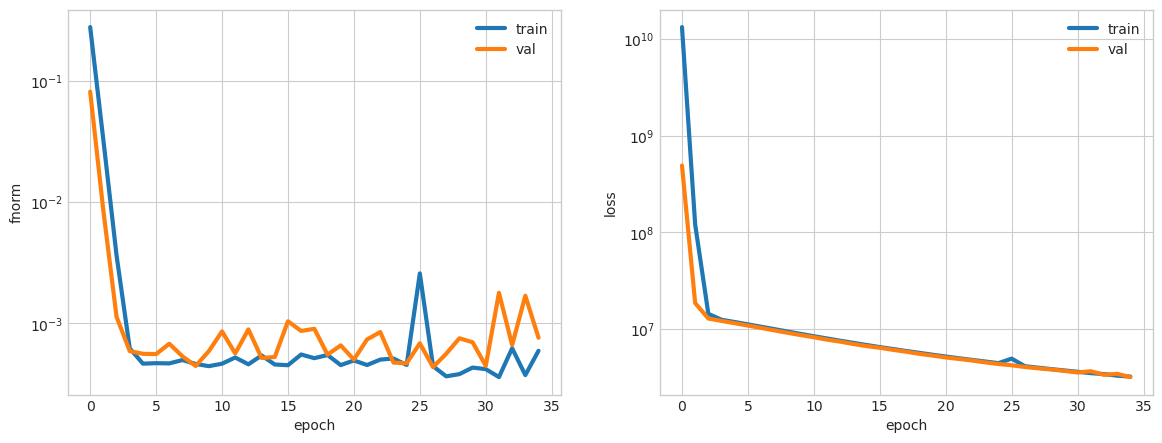

In [41]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics,tags=["fnorm","loss"])
metrics.iloc[::max(1,len(metrics)//10)]

## Operator Learning Classic

In [50]:
dataset_classic_train = qp.DatasetClassicOpLearn(uticks_train,vopt_train[:,-1,:],device=DEVICE,fp32=False)
dataset_classic_val = qp.DatasetClassicOpLearn(uticks_val,vopt_val[:,-1,:],device=DEVICE,fp32=False)
dataloader_classic_train = torch.utils.data.DataLoader(dataset_classic_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_classic_val = torch.utils.data.DataLoader(dataset_classic_val,batch_size=len(dataset_classic_val),collate_fn=tuple,shuffle=False)
print("len(dataset_classic_train):",len(dataset_classic_train))
print("len(dataset_classic_val):",len(dataset_classic_val))
print("len(dataloader_chonknoris_train):",len(dataloader_classic_train))
print("len(dataloader_chonknoris_val):",len(dataloader_classic_val))

len(dataset_classic_train): 3584
len(dataset_classic_val): 512
len(dataloader_chonknoris_train): 14
len(dataloader_chonknoris_val): 1


### GP

## Inference

In [42]:
#noris = noris_mlp
noris = noris_gp

In [48]:
class NORISPrecond(qp.kernel_methods.pcg_module.preconditioners._BasePrecond):
    def __init__(self, v):
        self.v = v
    def solve(self, y):
        x = noris.linsolve(y,self.v)
        return x
noris.eval()
noris.to("cpu")
ridxs = [0,1,2,7]
maxiter = 10
numrs = len(ridxs)
vhat = [None]*numrs
numpreds = maxiter+1
data_refs = [None]*numrs
datas = [None]*numrs
L_chol_hats = torch.nan*torch.empty((numrs,maxiter,L_chols.size(-1),L_chols.size(-1)),dtype=noris.ftype)
for i,r in enumerate(ridxs):
    print("ridxs[%d] = %d"%(i,r))
    L_chols_hats_i = [None]*maxiter
    j = 0
    def custom_lin_solver(v, y):
        global j
        x,L_chol_hats[i,j] = noris.linsolve(y,v,return_L_hat=True)
        j += 1
        return x
    def pde_lhs_r(ly_i, ly_b):
        v_i,v_laplace_i = ly_i
        v_b = ly_b[0]
        lhs_i = C1*v_i**3+C2*v_laplace_i
        lhs_b = v_b
        return lhs_i,lhs_b
    def pde_rhs_r(x_i, x_b):
        y_i = uticks_val[r]
        y_b = torch.zeros(len(x_b),dtype=float)
        return y_i,y_b
    print("  Chol Direct")
    y,datas[i] = ki.pde_opt_gauss_newton(
            pde_lhs = pde_lhs_r,
            pde_rhs = pde_rhs_r,
            maxiter = maxiter,
            custom_lin_solver = custom_lin_solver,
            verbose = False)
    # print("  True CG")
    # y_ref_r,data_refs[i] = ki.pde_opt_gauss_newton(
    #     pde_lhs = pde_lhs_r,
    #     pde_rhs = pde_rhs_r,
    #     maxiter = maxiter,
    #     precond_setter = lambda x: qp.kernel_methods.IdentityPrecond(),#lambda pde_gm: NORISPrecond(pde_gm.z),
    #     verbose = 2)
    # print("  Neural PCG")
    # y_r,datas[i] = ki.pde_opt_gauss_newton(
    #     pde_lhs = pde_lhs_r,
    #     pde_rhs = pde_rhs_r,
    #     maxiter = maxiter,
    #     precond_setter = lambda pde_gm: NORISPrecond(pde_gm.z),
    #     verbose = 2)
    vhat[i] = datas[i]["zhist"][:,:nxticks]
    print()
vhat = torch.stack(vhat)
l2rerrors = torch.linalg.norm(vhat-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat[:,:min(vopt_val.size(1),numpreds),:]-vopt_val[ridxs,:numpreds,:nxticks],dim=2)/torch.linalg.norm(vopt_val[ridxs,:numpreds,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[ridxs,:])
with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("l2rerrors_iter")
    print(l2rerrors_iter.numpy())
    print()
    print("l2rerrors")
    print(l2rerrors.numpy())
    print()

ridxs[0] = 0
  Chol Direct
  True CG
    iter (10 max)  loss           time           K(A)           K(P)           K(P)/K(A)      PCG rberror    PCG steps (53 max)
    0              1.00e+01                      
    1              1.68e-01       4.09e-03       6.8e+07        6.8e+07        1.0e+00        1.7e-02        53
    2              7.53e-01       7.58e-03       6.7e+07        6.7e+07        1.0e+00        7.5e-02        53
    3              1.06e+00       1.09e-02       6.7e+07        6.7e+07        1.0e+00        1.1e-01        53
    4              1.21e+00       1.41e-02       6.7e+07        6.7e+07        1.0e+00        1.2e-01        53
    5              1.02e+00       1.75e-02       6.7e+07        6.7e+07        1.0e+00        1.0e-01        53
    6              1.59e+00       2.07e-02       6.7e+07        6.7e+07        1.0e+00        1.6e-01        53
    7              1.27e+00       2.40e-02       6.7e+07        6.7e+07        1.0e+00        1.3e-01        53
 

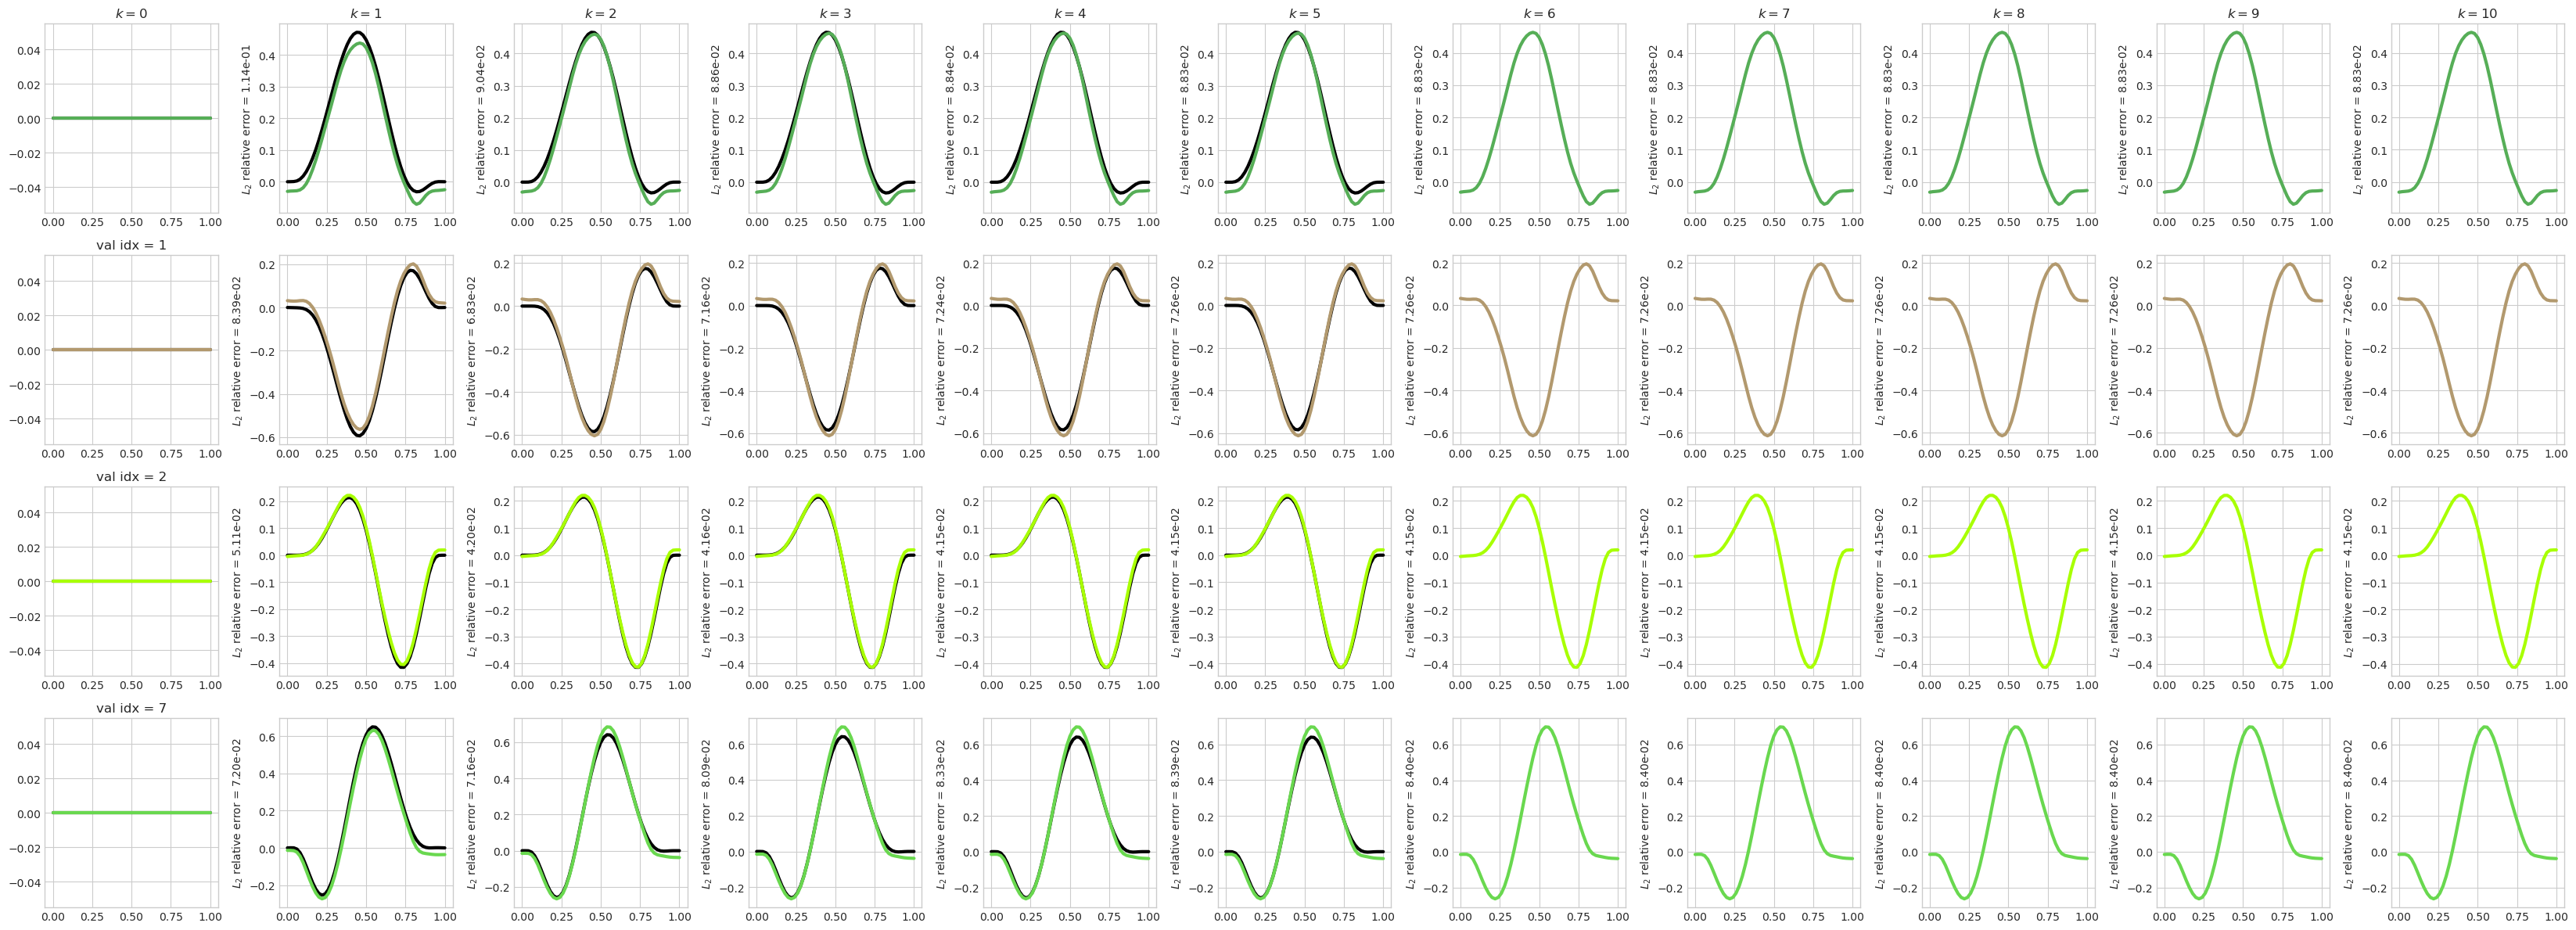

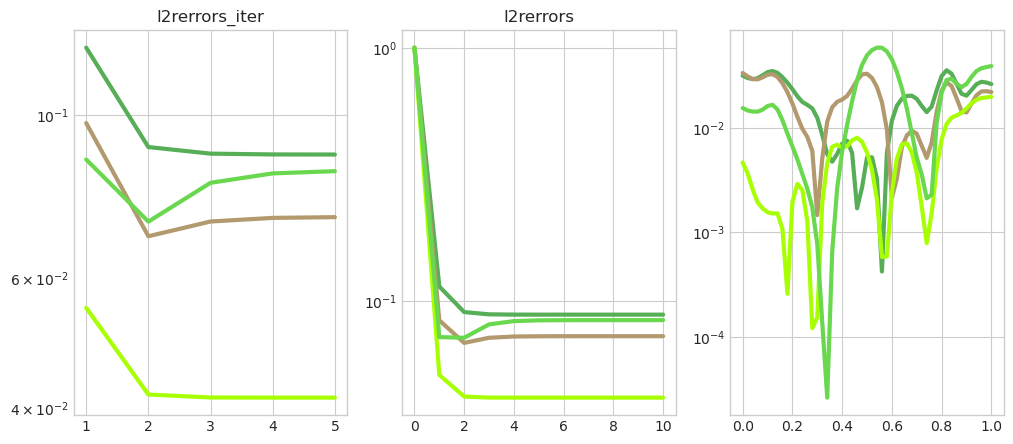

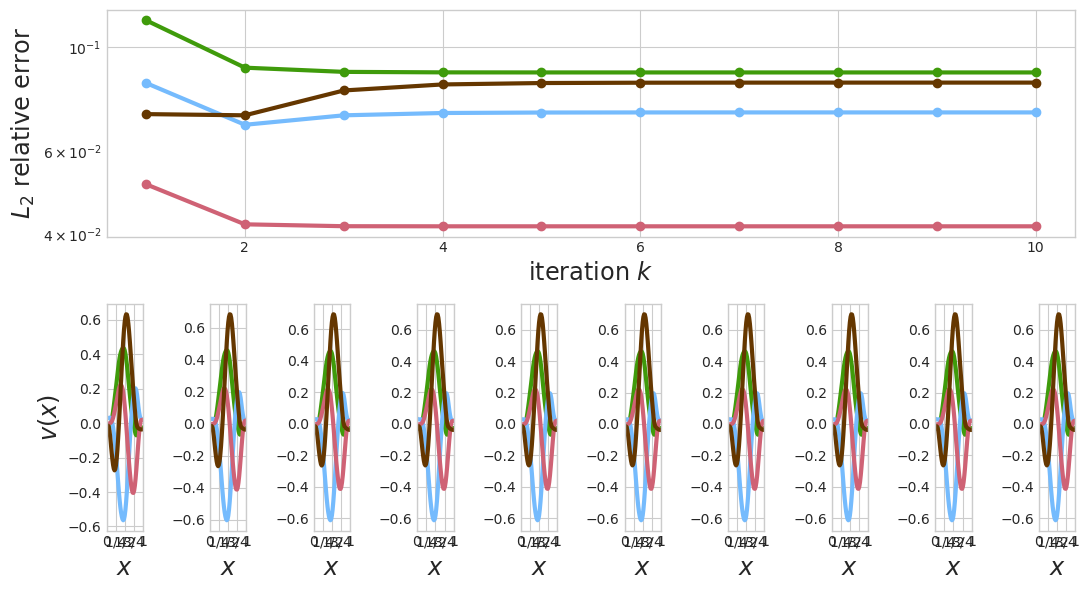

In [47]:
fig,ax = pyplot.subplots(nrows=numrs,ncols=numpreds,figsize=(3*numpreds,3*numrs))
for i in range(numrs):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(numpreds):
        if k<vopt.size(1):
            ax[i,k].plot(xticks,vopt_val[ridxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(numrs):
    ax[i,0].set_title("val idx = %d"%ridxs[i])
for k in range(numpreds):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()
fig.show()
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
for i in range(numrs):
    ax[0].plot(torch.arange(len(l2rerrors_iter[i])),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(torch.arange(numpreds),l2rerrors[i],linewidth=LW,color=COLORS[i])
    ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
ax[0].set_title("l2rerrors_iter")
ax[1].set_title("l2rerrors")
for i in range(3):
    ax[i].set_yscale("log",base=10)
fig.show()
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,numpreds-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(numrs):
    ax.plot(torch.arange(1,numpreds),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,numpreds-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(numpreds-1,dtype=object)
for k in range(numpreds-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    #ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat[:,1:numpreds,:nxticks].min(),vhat[:,1:numpreds,:nxticks].max()
for k in range(numpreds-1):
    for i in range(numrs):
        ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,numpreds-1):
    pass#ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
#fig.savefig("./superres.png",dpi=512,bbox_inches="tight")

In [44]:
# fig,ax = pyplot.subplots(nrows=3,ncols=numpreds,figsize=(3*numpreds,3*2))
# for k in range(maxiter):
#     L_inv_true = torch.linalg.solve_triangular(
#         L_chols_val[ridxs[0],k],
#         torch.eye(nxticks+2,dtype=L_chols_val.dtype),
#         upper=False)
#     err = (L_chol_hats[0,k]-L_inv_true.cpu()).abs()
#     ax[0,k].imshow(L_inv_true.abs(),norm=colors.LogNorm(),cmap=cm.cool)
#     ax[0,k].set_title("%.1f\t%.1f"%(L_inv_true.abs().max(),L_inv_true.abs().mean()))
#     ax[1,k].imshow(L_chol_hats[0,k],norm=colors.LogNorm(),cmap=cm.cool)
#     ax[1,k].set_title("%.1f\t%.1f"%(L_chol_hats.abs().max(),L_chol_hats.abs().mean()))
#     ax[2,k].imshow(err,norm=colors.LogNorm(),cmap=cm.cool)
#     ax[2,k].set_title("%.1f\t%.1f"%(err.abs().max(),err.abs().mean()))

In [45]:
# fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
# for i in range(numrs):
#     ax.plot(torch.cat(data_refs[i]["times"]),color=COLORS[i]);
#     ax.plot(torch.cat(datas[i]["times"]),color=COLORS[i],linestyle="--");